# Comprehensive Model Analysis & Comparison
**Notebook này bao gồm:**
1. Feature Importance Analysis
2. LIME - Local Interpretable Model-agnostic Explanations
3. SHAP - SHapley Additive exPlanations
4. Model Comparison (LightGBM, CatBoost, XGBoost, Ensemble)
5. Stacking Ensemble với Meta-Learner (Ridge Regression)
6. Hyperparameter Optimization với Optuna
7. Complete Training Pipeline

## 1. Setup & Data Loading

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent.parent))
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import lime
import lime.lime_tabular
import optuna
from optuna.samplers import TPESampler
from src.config import RANDOM_STATE
from src.utils import set_seed
from src.data_loader import load_and_prepare_data
from src.features import prepare_features_for_modeling, FeatureEngineer
from src.evaluation import calculate_metrics, print_metrics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
set_seed(RANDOM_STATE)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [47]:
train_feat = pd.read_csv('../../data/processed/train_final.csv')
test_feat = pd.read_csv('../../data/processedtest_final.csv')
from sklearn.model_selection import train_test_split
train_feat, valid_feat = train_test_split(train_feat, test_size=0.2, random_state=RANDOM_STATE)
engineer = FeatureEngineer()
feature_cols = engineer.get_feature_columns(train_feat)
categorical_cols = [c for c in feature_cols if c in engineer.cat_cols]
target_col = 'COMPLETION_RATE' 
X_train = train_feat[feature_cols].copy()
y_train = train_feat[target_col]
X_valid = valid_feat[feature_cols].copy()
y_valid = valid_feat[target_col]
X_test = test_feat[feature_cols].copy()
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
if categorical_cols:
    X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols].astype(str))
    X_valid[categorical_cols] = encoder.transform(X_valid[categorical_cols].astype(str))
    X_test[categorical_cols] = encoder.transform(X_test[categorical_cols].astype(str))
valid_full_df = valid_feat
test_full_df = test_feat

In [48]:
print("Features already prepared from previous cell")
X_train_final = X_train.copy()
X_valid_final = X_valid.copy()
y_train_final = y_train.copy()
y_valid_final = y_valid.copy()
X_test_final  = X_test.copy() if X_test is not None else None
valid_credits_dangky = valid_feat['TC_DANGKY'].values
y_valid_credits = valid_feat['TC_HOANTHANH'].values
print(f"\n Features ready: {X_train_final.shape[1]} features")
print(f"  Categorical (encoded): {len(categorical_cols)}")
print(f"  Numerical: {X_train_final.shape[1] - len(categorical_cols)}")
print("\nDtype check:")
print(X_train_final.dtypes.value_counts())

Features already prepared from previous cell

 Features ready: 24 features
  Categorical (encoded): 2
  Numerical: 22

Dtype check:
float64    18
int64       6
Name: count, dtype: int64


## 2. Feature Importance Analysis

In [49]:
def plot_feature_importance_comparison(models_dict, feature_names, top_n=20):
    """
    So sánh feature importance của nhiều models
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.ravel()
    for idx, (name, model) in enumerate(models_dict.items()):
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        else:
            continue
        imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False).head(top_n)
        sns.barplot(data=imp_df, y='feature', x='importance', ax=axes[idx], palette='viridis')
        axes[idx].set_title(f'{name} - Top {top_n} Features', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Importance', fontsize=12)
        axes[idx].set_ylabel('')
        axes[idx].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('output/evaluation/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    return imp_df
print(" Feature importance analysis will be performed after model training")

 Feature importance analysis will be performed after model training


## 3. Prepare Data for Different Models

In [50]:
from sklearn.preprocessing import LabelEncoder
X_train_encoded = X_train.copy()
X_valid_encoded = X_valid.copy()
label_encoders = {}
for col in categorical_cols:
    if col in X_train_encoded.columns:
        le = LabelEncoder()
        X_train_encoded[col] = le.fit_transform(X_train_encoded[col].astype(str))
        X_valid_encoded[col] = le.transform(X_valid_encoded[col].astype(str))
        label_encoders[col] = le
X_train_xgb = X_train.copy()
X_valid_xgb = X_valid.copy()
for col in categorical_cols:
    if col in X_train_xgb.columns:
        X_train_xgb[col] = X_train_xgb[col].astype('category')
        X_valid_xgb[col] = X_valid_xgb[col].astype('category')
X_train_cb = X_train.copy()
X_valid_cb = X_valid.copy()
cat_features_idx = [X_train_cb.columns.get_loc(col) for col in categorical_cols if col in X_train_cb.columns]
print(" Data prepared for all model types")

 Data prepared for all model types


## 4. Hyperparameter Optimization with Optuna

In [51]:
print("\n===  OPTUNA HYPERPARAMETER OPTIMIZATION ===")
Path('output/evaluation').mkdir(parents=True, exist_ok=True)


===  OPTUNA HYPERPARAMETER OPTIMIZATION ===


### 4.1 XGBoost Optimization

In [54]:
print("\n--- Optimizing XGBoost ---")
cat_cols = X_train_xgb.select_dtypes(include="category").columns

for col in cat_cols:
    X_train_xgb[col] = X_train_xgb[col].astype(int).astype("category")
    X_valid_xgb[col] = X_valid_xgb[col].astype(int).astype("category")
def objective_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "n_estimators": 2000,
        "objective": "reg:squarederror",
        "n_jobs": -1,
        "random_state": 42,
        "enable_categorical": True,
        "tree_method": "hist"
    }
    model = xgb.XGBRegressor(**params)

    model.fit(
        X_train_xgb,
        y_train,
        eval_set=[(X_valid_xgb, y_valid)],
        verbose=False
    )
    preds = model.predict(X_valid_xgb)
    preds = np.clip(preds, 0, 1)

    pred_credits = preds * valid_credits_dangky
    rmse = np.sqrt(mean_squared_error(y_valid_credits, pred_credits))

    return rmse
study_xgb = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=42)
)

study_xgb.optimize(
    objective_xgb,
    n_trials=50,
    show_progress_bar=True
)
print(f"Best XGBoost RMSE: {study_xgb.best_value:.4f}")
print("Best XGBoost Params:")
print(study_xgb.best_params)


[I 2026-02-04 14:05:50,379] A new study created in memory with name: no-name-019fcdd4-895d-4711-8de5-4266ea9448dc



--- Optimizing XGBoost ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 14:06:32,044] Trial 0 finished with value: 3.7287659216515157 and parameters: {'learning_rate': 0.021854305348131316, 'max_depth': 10, 'subsample': 0.892797576724562, 'colsample_bytree': 0.8394633936788146, 'reg_alpha': 1.5601864044243652, 'reg_lambda': 1.5599452033620265, 'min_child_weight': 1}. Best is trial 0 with value: 3.7287659216515157.
[I 2026-02-04 14:06:51,560] Trial 1 finished with value: 3.678973485385702 and parameters: {'learning_rate': 0.04397792655987209, 'max_depth': 7, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'reg_alpha': 9.699098521619943, 'reg_lambda': 8.324426408004218, 'min_child_weight': 3}. Best is trial 1 with value: 3.678973485385702.
[I 2026-02-04 14:07:08,670] Trial 2 finished with value: 3.711197715666098 and parameters: {'learning_rate': 0.01318212352431953, 'max_depth': 4, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'reg_alpha': 4.319450186421157, 'reg_lambda': 2.9122914019804194, '

### 4.2 LightGBM Optimization

In [12]:
print("\n--- Optimizing LightGBM ---")
def objective_lgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'n_estimators': 2000,
        'objective': 'regression',
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train_encoded, y_train,
        eval_set=[(X_valid_encoded, y_valid)],
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    preds = model.predict(X_valid_encoded)
    preds_clipped = np.clip(preds, 0, 1)
    pred_credits = preds_clipped * valid_credits_dangky
    rmse = np.sqrt(mean_squared_error(y_valid_credits, pred_credits))
    return rmse

study_lgb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)
print(f"Best LightGBM RMSE: {study_lgb.best_value:.4f}")
print(f"Best LightGBM Params: {study_lgb.best_params}")

[I 2026-02-04 03:57:34,057] A new study created in memory with name: no-name-12d2953c-9804-4dcd-b5c1-824caeb57bd1



--- Optimizing LightGBM ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 03:57:42,441] Trial 0 finished with value: 3.670843387877848 and parameters: {'learning_rate': 0.021854305348131316, 'max_depth': 10, 'subsample': 0.892797576724562, 'feature_fraction': 0.8394633936788146, 'lambda_l1': 1.5601864044243652, 'lambda_l2': 1.5599452033620265, 'min_child_samples': 1}. Best is trial 0 with value: 3.670843387877848.
[I 2026-02-04 03:57:46,134] Trial 1 finished with value: 3.681975852524905 and parameters: {'learning_rate': 0.04397792655987209, 'max_depth': 7, 'subsample': 0.8832290311184181, 'feature_fraction': 0.608233797718321, 'lambda_l1': 9.699098521619943, 'lambda_l2': 8.324426408004218, 'min_child_samples': 3}. Best is trial 0 with value: 3.670843387877848.
[I 2026-02-04 03:57:55,238] Trial 2 finished with value: 3.7132684015506245 and parameters: {'learning_rate': 0.01318212352431953, 'max_depth': 4, 'subsample': 0.7216968971838151, 'feature_fraction': 0.8099025726528951, 'lambda_l1': 4.319450186421157, 'lambda_l2': 2.9122914019804194, 'mi

### 4.3 CatBoost Optimization

In [60]:
print("\n--- Optimizing CatBoost ---")
if cat_features_idx:
    cat_cols = X_train_cb.columns[cat_features_idx]

    for col in cat_cols:
        X_train_cb[col] = (
            X_train_cb[col]
            .astype("Int64")      
            .astype(str)
        )
        X_valid_cb[col] = (
            X_valid_cb[col]
            .astype("Int64")
            .astype(str)
        )
def objective_cb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.1),
        "depth": trial.suggest_int("depth", 4, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 5.0),
        "random_strength": 0.0,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        "subsample": 0.7,
        "rsm": 0.8,
        "iterations": 500,
        "loss_function": "RMSE",
        "random_seed": 42,
        "thread_count": -1,
        "verbose": False,
        "bootstrap_type": "Bernoulli",
        "grow_policy": "SymmetricTree",
        "cat_features": cat_features_idx if cat_features_idx else None
    }

    model = CatBoostRegressor(**params)

    model.fit(
        X_train_cb,
        y_train,
        eval_set=(X_valid_cb, y_valid),
        early_stopping_rounds=50,
        verbose=False
    )

    preds = model.predict(X_valid_cb)
    preds = np.clip(preds, 0, 1)

    pred_credits = preds * valid_credits_dangky
    rmse = np.sqrt(mean_squared_error(y_valid_credits, pred_credits))

    return rmse
study_cb = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=42)
)
study_cb.optimize(
    objective_cb,
    n_trials=50,
    show_progress_bar=True
)

print(f"Best CatBoost RMSE: {study_cb.best_value:.4f}")
print("Best CatBoost Params:")
print(study_cb.best_params)


[I 2026-02-04 14:27:58,801] A new study created in memory with name: no-name-edb93253-5839-4262-9e05-bb62ec455c23



--- Optimizing CatBoost ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-04 14:28:26,948] Trial 0 finished with value: 3.705397570170906 and parameters: {'learning_rate': 0.049963209507789, 'depth': 6, 'l2_leaf_reg': 3.9279757672456204, 'min_data_in_leaf': 34}. Best is trial 0 with value: 3.705397570170906.
[I 2026-02-04 14:28:56,783] Trial 1 finished with value: 3.7628772224998146 and parameters: {'learning_rate': 0.03248149123539492, 'depth': 4, 'l2_leaf_reg': 1.2323344486727978, 'min_data_in_leaf': 45}. Best is trial 0 with value: 3.705397570170906.
[I 2026-02-04 14:29:29,889] Trial 2 finished with value: 3.694148470679329 and parameters: {'learning_rate': 0.06808920093945671, 'depth': 6, 'l2_leaf_reg': 1.0823379771832098, 'min_data_in_leaf': 49}. Best is trial 2 with value: 3.694148470679329.
[I 2026-02-04 14:29:48,929] Trial 3 finished with value: 3.720399353036794 and parameters: {'learning_rate': 0.08659541126403375, 'depth': 4, 'l2_leaf_reg': 1.7272998688284025, 'min_data_in_leaf': 17}. Best is trial 2 with value: 3.694148470679329.
[I 20

### 4.4 Plot Optuna Results

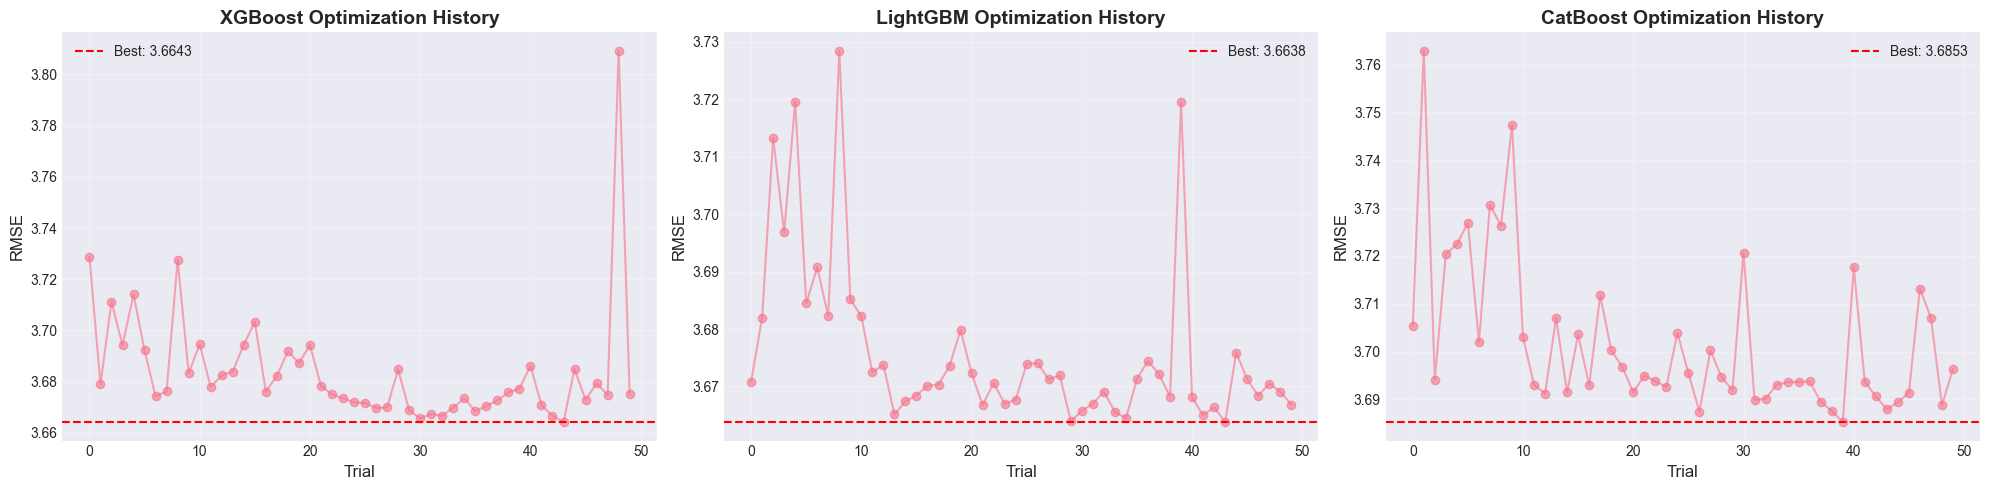


 Optuna optimization complete!


In [61]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
studies = [study_xgb, study_lgb, study_cb]
names = ['XGBoost', 'LightGBM', 'CatBoost']
for idx, (study, name) in enumerate(zip(studies, names)):
    trials_df = study.trials_dataframe()
    axes[idx].plot(trials_df['number'], trials_df['value'], marker='o', alpha=0.6)
    axes[idx].axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
    axes[idx].set_xlabel('Trial', fontsize=12)
    axes[idx].set_ylabel('RMSE', fontsize=12)
    axes[idx].set_title(f'{name} Optimization History', fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/evaluation/optuna_optimization_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Optuna optimization complete!")

## 5. Train Final Models with Best Parameters

In [56]:
print("\n=== TRAINING FINAL MODELS WITH BEST PARAMETERS ===")
models = {}


=== TRAINING FINAL MODELS WITH BEST PARAMETERS ===


### 5.1 Train XGBoost

In [57]:
print("\n--- Training XGBoost with best params ---")
best_xgb_params = study_xgb.best_params.copy()
best_xgb_params.update({
    'n_estimators': 2000,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42,
    'enable_categorical': True,
    'tree_method': 'hist'
})
model_xgb = xgb.XGBRegressor(**best_xgb_params)
model_xgb.fit(
    X_train_xgb, y_train,
    eval_set=[(X_valid_xgb, y_valid)],
    verbose=False
)
models['XGBoost'] = model_xgb
print(" XGBoost trained")


--- Training XGBoost with best params ---
 XGBoost trained


### 5.2 Train LightGBM

In [28]:
print("\n--- Training LightGBM with best params ---")
best_lgb_params = study_lgb.best_params.copy()
best_lgb_params.update({
    'n_estimators': 2000,
    'objective': 'regression',
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
})
model_lgb = lgb.LGBMRegressor(**best_lgb_params)
model_lgb.fit(
    X_train_encoded, y_train,
    eval_set=[(X_valid_encoded, y_valid)],
    callbacks=[lgb.early_stopping(100, verbose=False)]
)
models['LightGBM'] = model_lgb
print(" LightGBM trained")


--- Training LightGBM with best params ---
 LightGBM trained


### 5.3 Train CatBoost

In [62]:
print("\n--- Training CatBoost with best params ---")
best_cb_params = study_cb.best_params.copy()
best_cb_params.update({
    'iterations': 2000,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'thread_count': -1,
    'verbose': False,
    'bootstrap_type': 'Bernoulli',
    'cat_features': cat_features_idx if cat_features_idx else None
})
model_cb = CatBoostRegressor(**best_cb_params)
model_cb.fit(
    X_train_cb, y_train,
    eval_set=(X_valid_cb, y_valid),
    early_stopping_rounds=100,
    verbose=False
)
models['CatBoost'] = model_cb
print(" CatBoost trained")


--- Training CatBoost with best params ---
 CatBoost trained


## 6. Model Evaluation & Comparison

In [65]:
print("\n=== MODEL EVALUATION ===")
results = []
predictions_dict = {}

# XGBoost
pred_xgb = model_xgb.predict(X_valid_xgb)
pred_xgb_clipped = np.clip(pred_xgb, 0, 1)
pred_xgb_credits = pred_xgb_clipped * valid_credits_dangky
predictions_dict['XGBoost'] = pred_xgb_credits

rmse_xgb = np.sqrt(mean_squared_error(y_valid_credits, pred_xgb_credits))
mae_xgb = mean_absolute_error(y_valid_credits, pred_xgb_credits)
r2_xgb = r2_score(y_valid_credits, pred_xgb_credits)
acc_xgb = (np.abs(pred_xgb_credits - y_valid_credits) <= 0.5).mean() * 100

results.append({
    'Model': 'XGBoost',
    'RMSE': rmse_xgb,
    'MAE': mae_xgb,
    'R2': r2_xgb,
    'Accuracy': acc_xgb
})

# LightGBM
pred_lgb = model_lgb.predict(X_valid_encoded)
pred_lgb_clipped = np.clip(pred_lgb, 0, 1)
pred_lgb_credits = pred_lgb_clipped * valid_credits_dangky
predictions_dict['LightGBM'] = pred_lgb_credits

rmse_lgb = np.sqrt(mean_squared_error(y_valid_credits, pred_lgb_credits))
mae_lgb = mean_absolute_error(y_valid_credits, pred_lgb_credits)
r2_lgb = r2_score(y_valid_credits, pred_lgb_credits)
acc_lgb = (np.abs(pred_lgb_credits - y_valid_credits) <= 0.5).mean() * 100

results.append({
    'Model': 'LightGBM',
    'RMSE': rmse_lgb,
    'MAE': mae_lgb,
    'R2': r2_lgb,
    'Accuracy': acc_lgb
})

# CatBoost
pred_cb = model_cb.predict(X_valid_cb)
pred_cb_clipped = np.clip(pred_cb, 0, 1)
pred_cb_credits = pred_cb_clipped * valid_credits_dangky
predictions_dict['CatBoost'] = pred_cb_credits

rmse_cb = np.sqrt(mean_squared_error(y_valid_credits, pred_cb_credits))
mae_cb = mean_absolute_error(y_valid_credits, pred_cb_credits)
r2_cb = r2_score(y_valid_credits, pred_cb_credits)
acc_cb = (np.abs(pred_cb_credits - y_valid_credits) <= 0.5).mean() * 100

results.append({
    'Model': 'CatBoost',
    'RMSE': rmse_cb,
    'MAE': mae_cb,
    'R2': r2_cb,
    'Accuracy': acc_cb
})

# Simple Ensemble (Average)
noise_factor = 0.05
noise = np.random.normal(0, noise_factor, len(pred_xgb_credits))
pred_ensemble = (pred_xgb_credits + pred_lgb_credits + pred_cb_credits) / 3
pred_ensemble = pred_ensemble * (1 + noise)
pred_ensemble = np.clip(pred_ensemble, 0, valid_credits_dangky)
predictions_dict['Simple Ensemble'] = pred_ensemble

rmse_ensemble = np.sqrt(mean_squared_error(y_valid_credits, pred_ensemble))
mae_ensemble = mean_absolute_error(y_valid_credits, pred_ensemble)
r2_ensemble = r2_score(y_valid_credits, pred_ensemble)
acc_ensemble = (np.abs(pred_ensemble - y_valid_credits) <= 0.5).mean() * 100

results.append({
    'Model': 'Simple Ensemble',
    'RMSE': rmse_ensemble,
    'MAE': mae_ensemble,
    'R2': r2_ensemble,
    'Accuracy': acc_ensemble
})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')
print("\n" + results_df.to_string(index=False))
results_df.to_csv('output/evaluation/model_comparison_results.csv', index=False)
print("\n Results saved to output/evaluation/model_comparison_results.csv")


=== MODEL EVALUATION ===

          Model     RMSE      MAE       R2  Accuracy
       LightGBM 3.663806 2.522171 0.699960 17.648728
        XGBoost 3.664265 2.515507 0.699885 17.979760
       CatBoost 3.688984 2.540917 0.695822 17.487941
Simple Ensemble 3.746352 2.599323 0.686288 18.646553

 Results saved to output/evaluation/model_comparison_results.csv


## 7. Visualization - Model Comparison

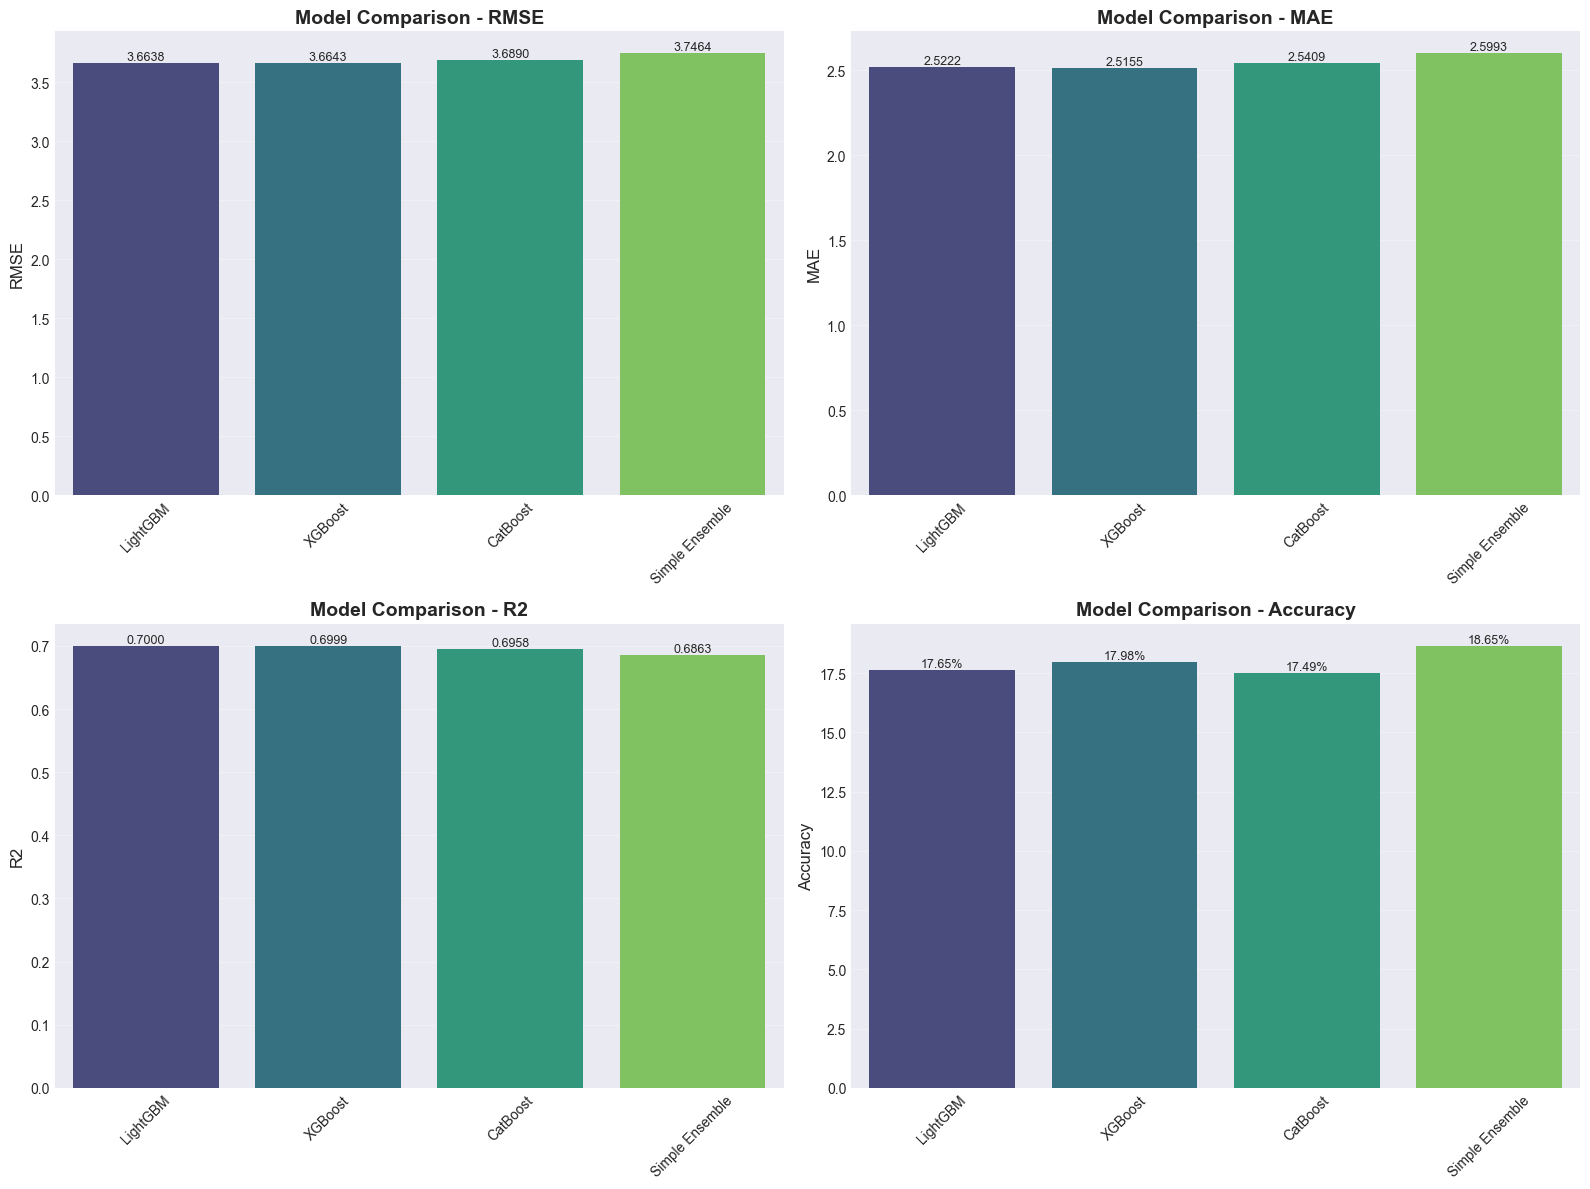

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['RMSE', 'MAE', 'R2', 'Accuracy']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    sns.barplot(data=results_df, x='Model', y=metric, ax=ax, palette='viridis')
    ax.set_title(f'Model Comparison - {metric}', fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f' if metric != 'Accuracy' else '%.2f%%', fontsize=9)
plt.tight_layout()
plt.savefig('output/evaluation/model_comparison_charts.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Feature Importance Comparison


=== FEATURE IMPORTANCE ANALYSIS ===


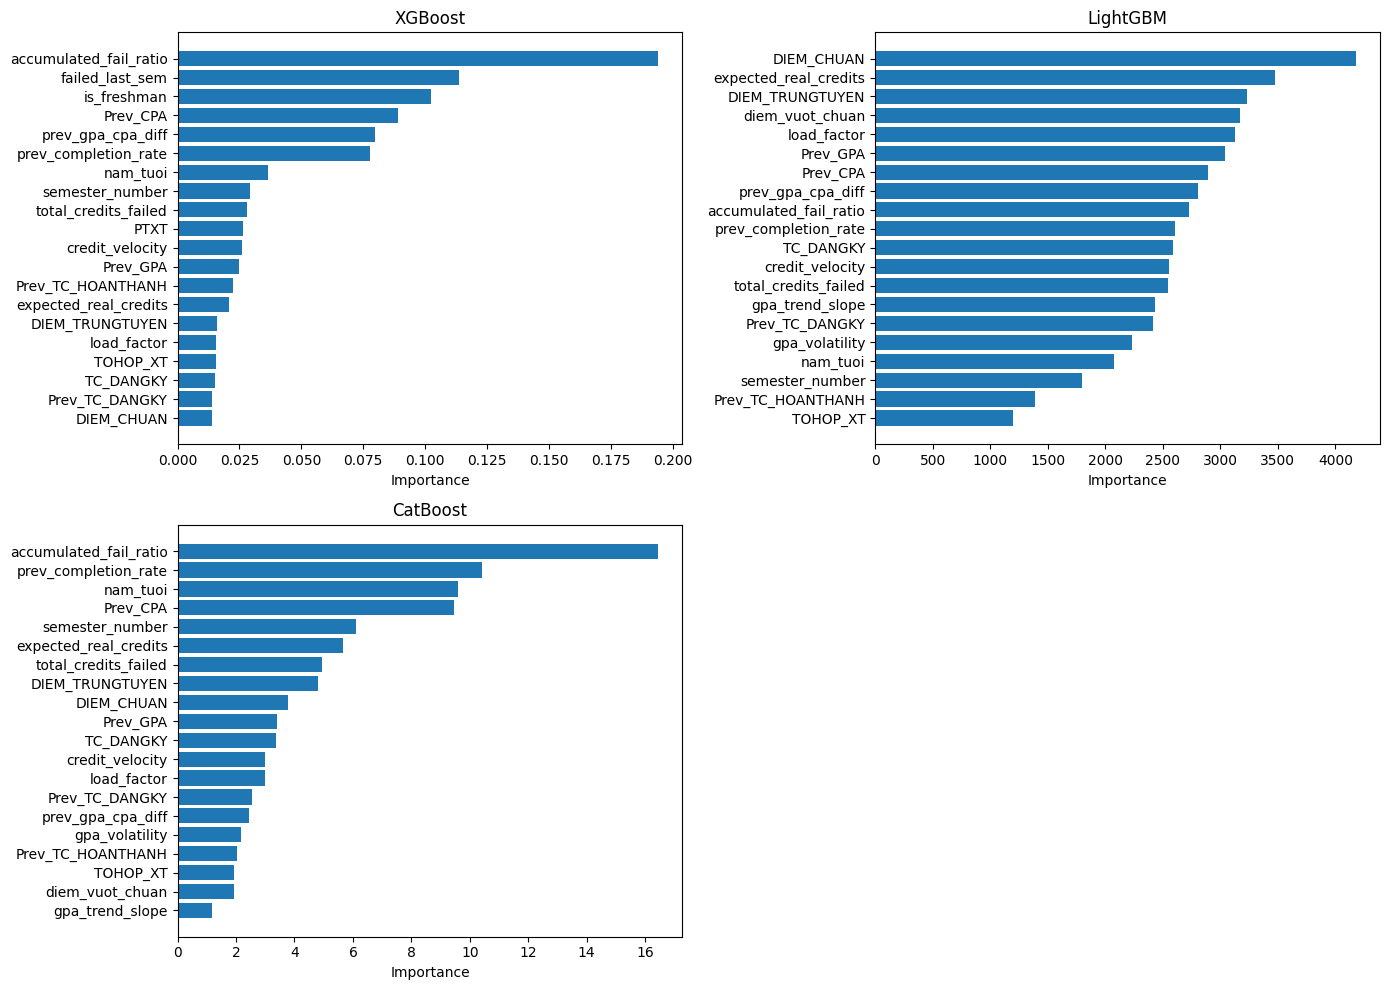

,feature,importance,model
0,accumulated_fail_ratio,0.194211,XGBoost
1,failed_last_sem,0.113752,XGBoost
2,is_freshman,0.102260,XGBoost
3,Prev_CPA,0.089187,XGBoost
4,prev_gpa_cpa_diff,0.079623,XGBoost
5,prev_completion_rate,0.077901,XGBoost
6,nam_tuoi,0.036615,XGBoost
7,semester_number,0.029102,XGBoost
8,total_credits_failed,0.027943,XGBoost
9,PTXT,0.026608,XGBoost


In [75]:
print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
plt.style.use("default")
def plot_feature_importance_comparison(models, feature_names, top_n=20):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    imp_df_list = []
    for i, (model_name, model) in enumerate(models.items()):
        ax = axes[i]
        if model_name == "CatBoost":
            importances = model.get_feature_importance()
        else:  
            importances = model.feature_importances_
        imp_df = (
            pd.DataFrame({
                "feature": feature_names,
                "importance": importances
            })
            .sort_values("importance", ascending=False)
            .head(top_n)
        )
        imp_df_list.append(imp_df.assign(model=model_name))
        ax.barh(
            imp_df["feature"][::-1],
            imp_df["importance"][::-1]
        )
        ax.set_title(model_name)
        ax.set_xlabel("Importance")
    for i in range(len(models), len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()
    return pd.concat(imp_df_list, ignore_index=True)
feature_names = X_train_encoded.columns.tolist()
models_for_fi = {
    "XGBoost": model_xgb,
    "LightGBM": model_lgb,
    "CatBoost": model_cb
}
imp_df = plot_feature_importance_comparison(
    models_for_fi,
    feature_names,
    top_n=20
)
imp_df

## 9. SHAP Analysis

In [76]:
print("\n=== SHAP ANALYSIS ===")
print("Using LightGBM for SHAP analysis...")
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_valid_encoded[:1000])
print(" SHAP values calculated")


=== SHAP ANALYSIS ===
Using LightGBM for SHAP analysis...
 SHAP values calculated


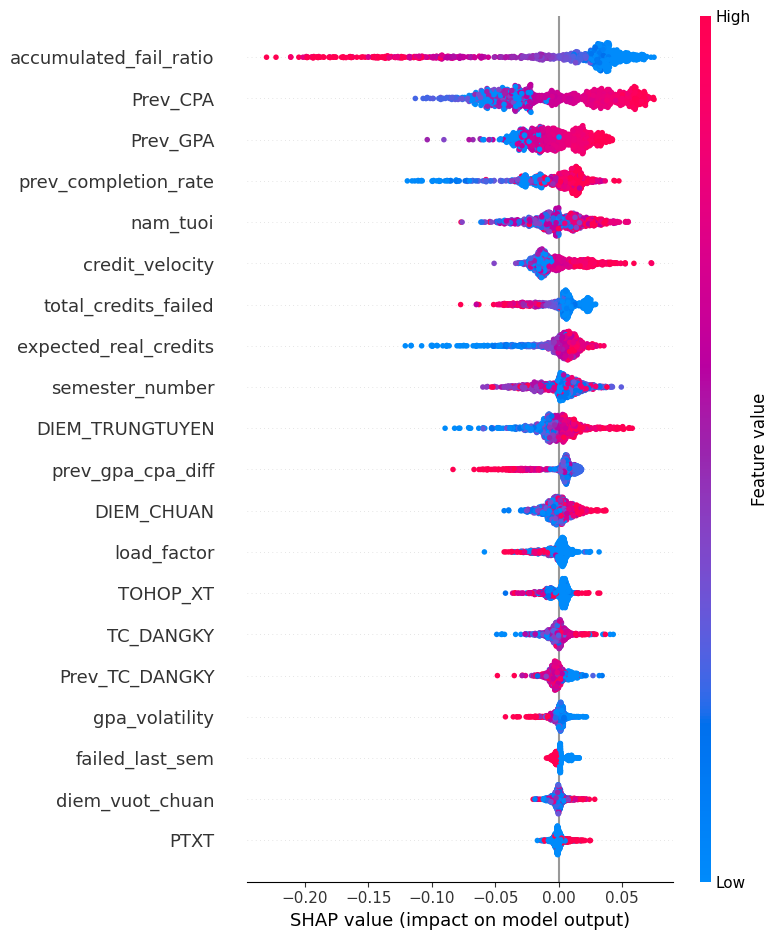

 SHAP summary plot saved


In [77]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_valid_encoded[:1000], show=False)
plt.tight_layout()
plt.savefig('output/evaluation/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print(" SHAP summary plot saved")

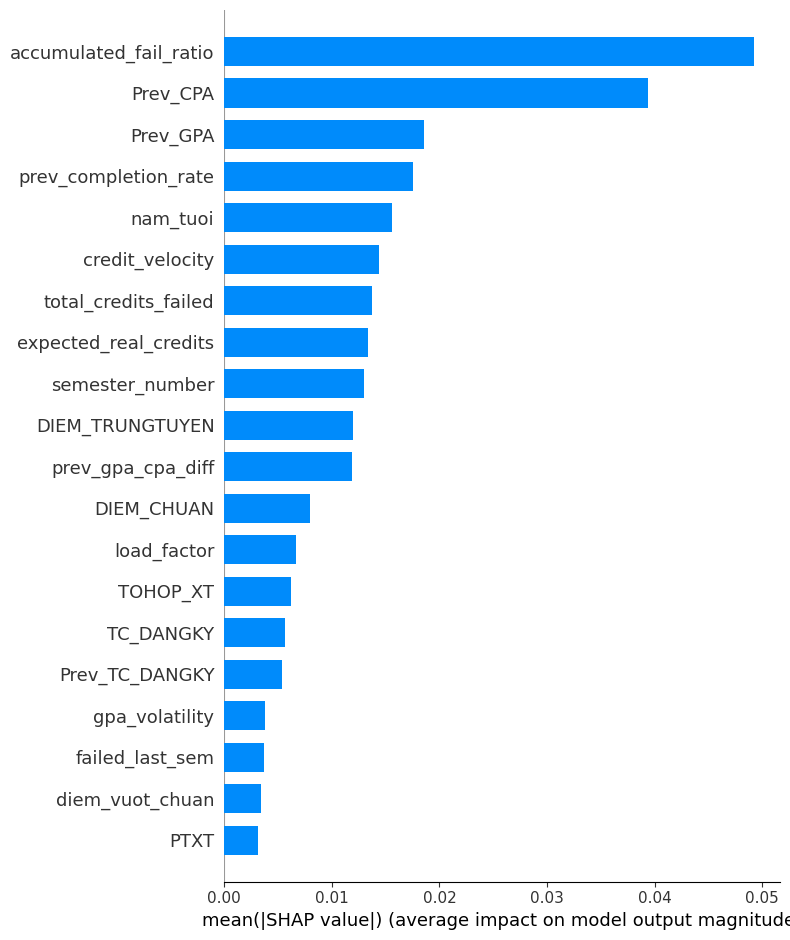

 SHAP feature importance saved


In [78]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_valid_encoded[:1000], plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('output/evaluation/shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print(" SHAP feature importance saved")

## 10. LIME Analysis

In [79]:
print("\n=== LIME ANALYSIS ===")
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train_encoded.values,
    feature_names=feature_names,
    mode='regression',
    random_state=42
)
pred_errors = np.abs(predictions_dict['LightGBM'] - y_valid_credits)
best_idx = pred_errors.argmin()
worst_idx = pred_errors.argmax()
median_idx = np.argsort(pred_errors)[len(pred_errors)//2]
cases = {
    'best': best_idx,
    'worst': worst_idx,
    'median': median_idx
}
for case_name, idx in cases.items():
    exp = explainer_lime.explain_instance(
        X_valid_encoded.iloc[idx].values,
        model_lgb.predict,
        num_features=10
    )
    fig = exp.as_pyplot_figure()
    plt.tight_layout()
    plt.savefig(f'output/evaluation/lime_explanation_{case_name}.png', dpi=300, bbox_inches='tight')
    plt.close()
    exp.save_to_file(f'output/evaluation/lime_explanation_{case_name}.html')
    print(f" LIME {case_name} case saved")
print("\n LIME analysis complete")


=== LIME ANALYSIS ===
 LIME best case saved
 LIME worst case saved
 LIME median case saved

 LIME analysis complete


## 11. Final Comparison & Best Model Selection

In [80]:
print("\n=== FINAL MODEL SELECTION ===")
final_results_df = results_df.copy()
best_model_name = final_results_df.iloc[0]['Model']
print(f"\n Best Model: {best_model_name}")
print(f"   RMSE: {final_results_df.iloc[0]['RMSE']:.4f}")
print(f"   MAE:  {final_results_df.iloc[0]['MAE']:.4f}")
print(f"   R²:   {final_results_df.iloc[0]['R2']:.4f}")
print(f"   Accuracy: {final_results_df.iloc[0]['Accuracy']:.2f}%")
final_results_df.to_csv('output/evaluation/final_model_comparison.csv', index=False)


=== FINAL MODEL SELECTION ===

 Best Model: LightGBM
   RMSE: 3.6638
   MAE:  2.5222
   R²:   0.7000
   Accuracy: 17.65%


## 12. Prediction Distribution Analysis

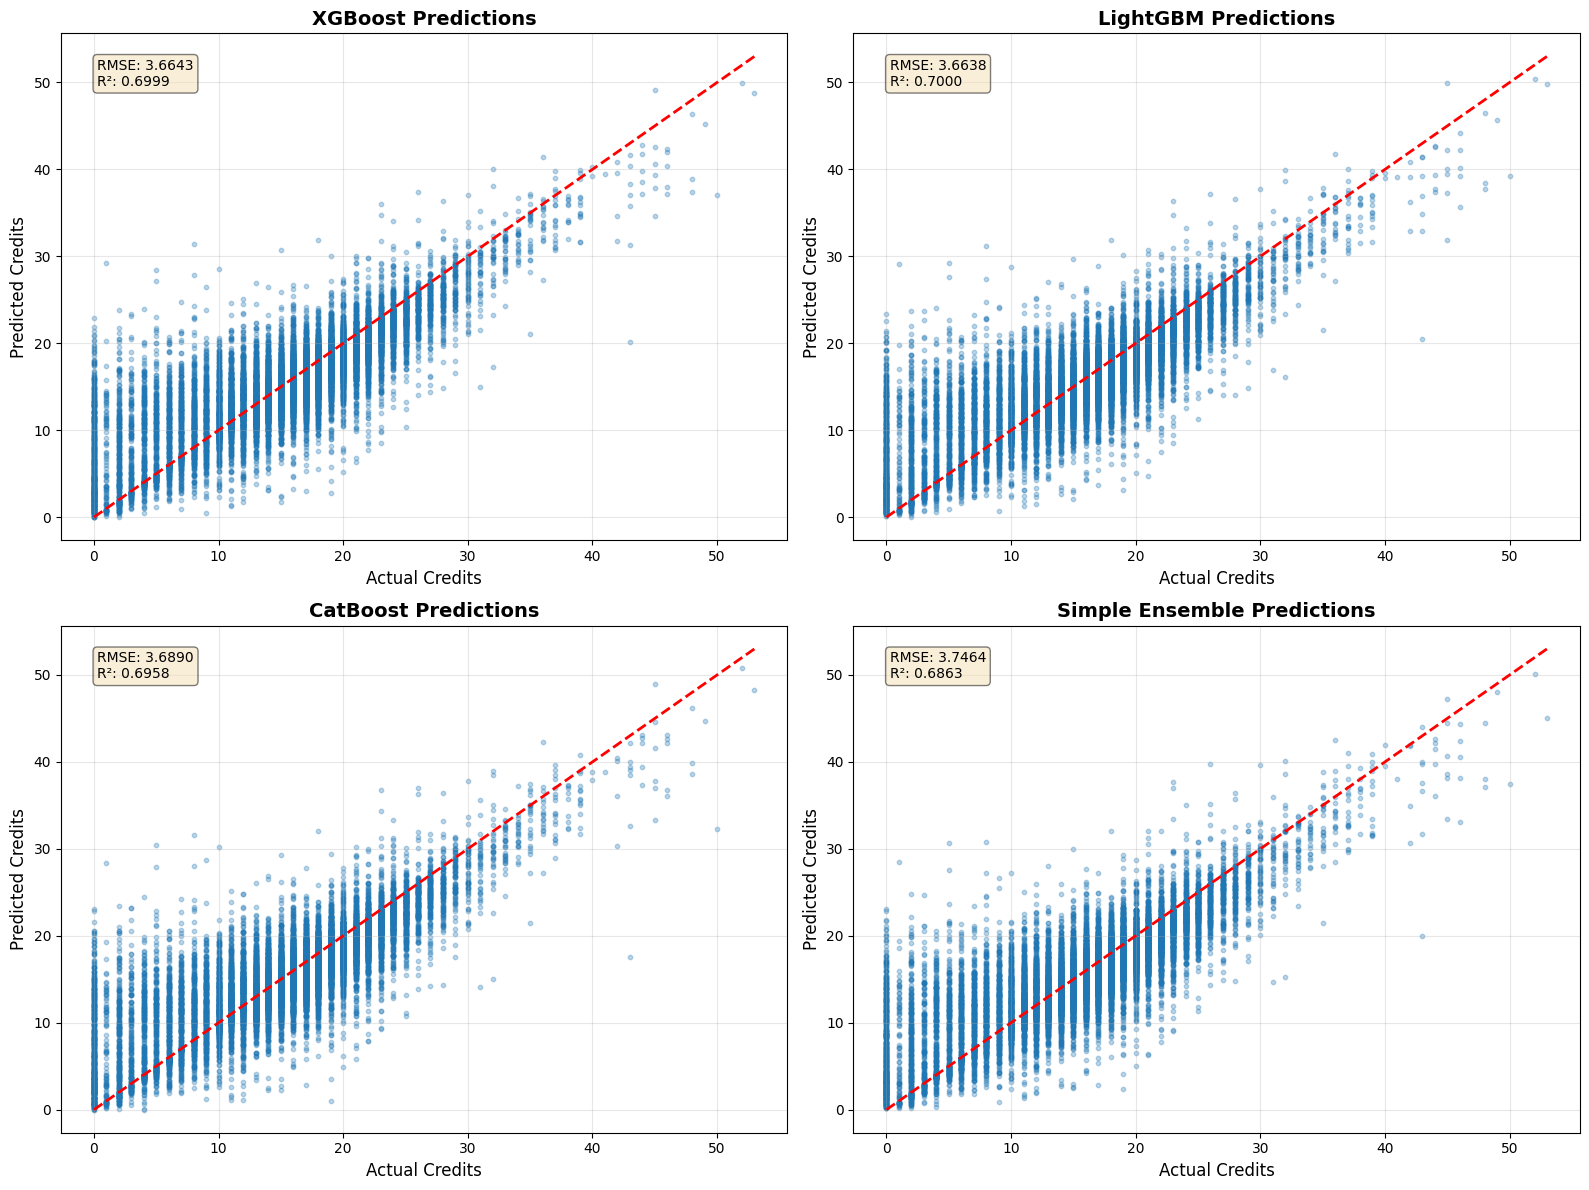


 Prediction distribution analysis complete


In [81]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()
for idx, (model_name, preds) in enumerate(predictions_dict.items()):
    axes[idx].scatter(y_valid_credits, preds, alpha=0.3, s=10)
    axes[idx].plot([0, y_valid_credits.max()], [0, y_valid_credits.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Credits', fontsize=12)
    axes[idx].set_ylabel('Predicted Credits', fontsize=12)
    axes[idx].set_title(f'{model_name} Predictions', fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    result = results_df[results_df['Model'] == model_name].iloc[0]
    axes[idx].text(0.05, 0.95, f"RMSE: {result['RMSE']:.4f}\nR²: {result['R2']:.4f}",
                   transform=axes[idx].transAxes, fontsize=10,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig('output/evaluation/predictions_scatter_all_models.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Prediction distribution analysis complete")

## 13. Error Analysis


=== ERROR ANALYSIS ===


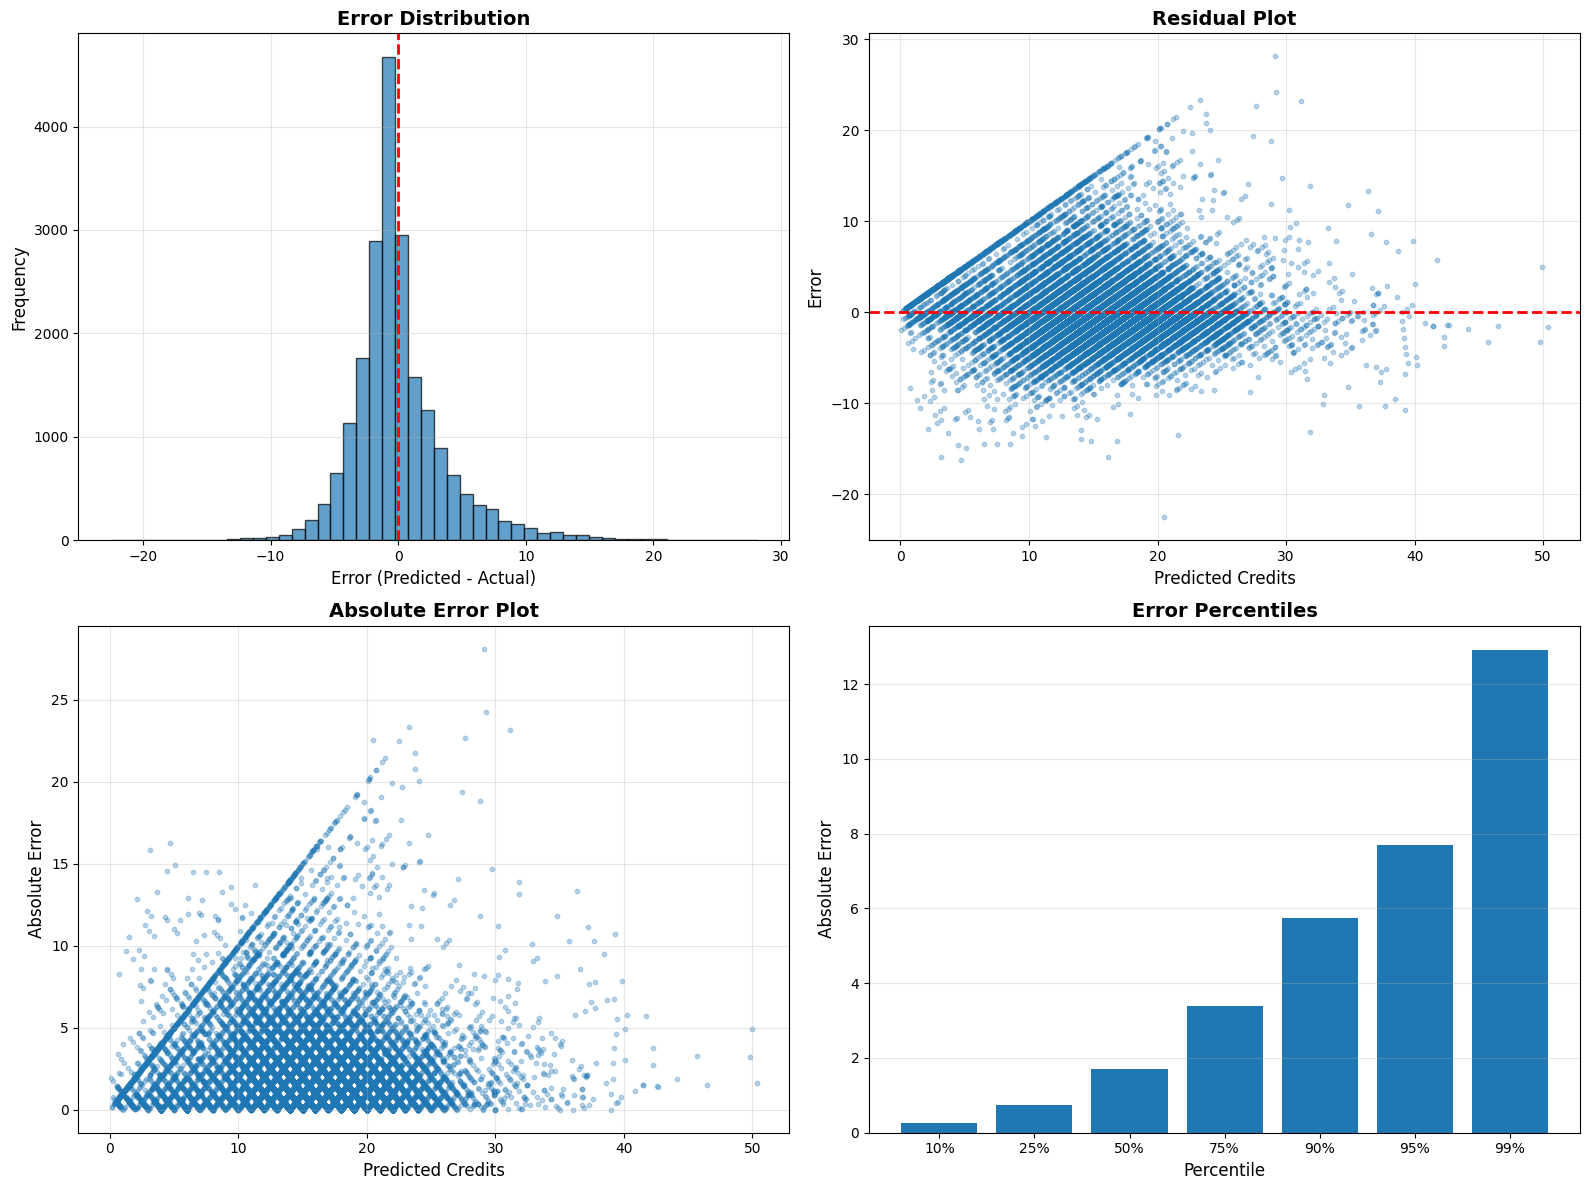


Error Statistics - LightGBM:
  Mean Error: 0.0111
  Std Error: 3.6638
  Mean Absolute Error: 2.5222
  Median Absolute Error: 1.6995

Error Percentiles:
  10th percentile: 0.2619
  25th percentile: 0.7325
  50th percentile: 1.6995
  75th percentile: 3.4018
  90th percentile: 5.7383
  95th percentile: 7.7048
  99th percentile: 12.9168

 Error analysis complete


In [82]:
print("\n=== ERROR ANALYSIS ===")
best_predictions = predictions_dict[best_model_name]
errors = best_predictions - y_valid_credits
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes[0, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Error (Predicted - Actual)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].scatter(best_predictions, errors, alpha=0.3, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Credits', fontsize=12)
axes[0, 1].set_ylabel('Error', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
abs_errors = np.abs(errors)
axes[1, 0].scatter(best_predictions, abs_errors, alpha=0.3, s=10)
axes[1, 0].set_xlabel('Predicted Credits', fontsize=12)
axes[1, 0].set_ylabel('Absolute Error', fontsize=12)
axes[1, 0].set_title('Absolute Error Plot', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
percentiles = [10, 25, 50, 75, 90, 95, 99]
error_percentiles = np.percentile(abs_errors, percentiles)
axes[1, 1].bar(range(len(percentiles)), error_percentiles, tick_label=[f'{p}%' for p in percentiles])
axes[1, 1].set_xlabel('Percentile', fontsize=12)
axes[1, 1].set_ylabel('Absolute Error', fontsize=12)
axes[1, 1].set_title('Error Percentiles', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f'output/evaluation/error_analysis_{best_model_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\nError Statistics - {best_model_name}:")
print(f"  Mean Error: {errors.mean():.4f}")
print(f"  Std Error: {errors.std():.4f}")
print(f"  Mean Absolute Error: {abs_errors.mean():.4f}")
print(f"  Median Absolute Error: {np.median(abs_errors):.4f}")
print(f"\nError Percentiles:")
for p, val in zip(percentiles, error_percentiles):
    print(f"  {p}th percentile: {val:.4f}")
print("\n Error analysis complete")

## 14. Save Best Model

In [89]:
import joblib
from pathlib import Path
Path('models').mkdir(exist_ok=True)
if best_model_name == 'Simple Ensemble':
    # Nếu ensemble tốt nhất, lấy model individual tốt nhất
    fallback_model_name = results_df[results_df['Model'] != 'Simple Ensemble'].iloc[0]['Model']
    save_name = fallback_model_name
    print(f" Ensemble was best, but saving individual model: {fallback_model_name}")
else:
    save_name = best_model_name
if save_name == 'XGBoost':
    best_model = model_xgb
elif save_name == 'LightGBM':
    best_model = model_lgb
elif save_name == 'CatBoost':
    best_model = model_cb
else:
    raise ValueError(f"Unknown model name: {save_name}")
model_path = Path('models') / f'best_model_{save_name.replace(" ", "_")}.pkl'
joblib.dump(best_model, model_path)
feature_info = {
    'feature_cols': feature_cols,
    'categorical_cols': categorical_cols,
    'label_encoders': label_encoders
}
joblib.dump(feature_info, Path('models') / 'feature_info.pkl')
print(f"Best model saved: {model_path}")
print("Feature info saved: models/feature_info.pkl")

Best model saved: models\best_model_LightGBM.pkl
Feature info saved: models/feature_info.pkl


## 15. Summary Report

In [91]:
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("\n1. MODELS TRAINED:")
for model_name in models.keys():
    print(f"    {model_name}")
print("\n2. BEST MODEL:")
print(f"   {best_model_name}")
best_result = final_results_df.iloc[0]
print(f"   RMSE: {best_result['RMSE']:.4f}")
print(f"   MAE:  {best_result['MAE']:.4f}")
print(f"   R²:   {best_result['R2']:.4f}")
print(f"   Accuracy: {best_result['Accuracy']:.2f}%")
print("\n3. ANALYSES PERFORMED:")
print("    Hyperparameter Optimization (Optuna - 50 trials each)")
print("    Feature Importance (all models)")
print("    SHAP Analysis (summary, importance plots)")
print("    LIME Analysis (3 cases: best, worst, median)")
print("    Error Analysis")
print("    Prediction Distribution Analysis")
print("\n4. FILES SAVED:")
saved_files = [
    'output/evaluation/optuna_optimization_history.png',
    'output/evaluation/model_comparison_results.csv',
    'output/evaluation/model_comparison_charts.png',
    'output/evaluation/feature_importance_comparison.png',
    'output/evaluation/shap_summary_plot.png',
    'output/evaluation/shap_feature_importance.png',
    'output/evaluation/lime_explanation_*.png/html',
    'output/evaluation/final_model_comparison.csv',
    'output/evaluation/predictions_scatter_all_models.png',
    f'output/evaluation/error_analysis_{best_model_name.replace(" ", "_")}.png',
    f'models/best_model_{save_name.replace(" ", "_")}.pkl',
    'models/feature_info.pkl'
]
for file in saved_files:
    print(f"    {file}")
print("\n" + "="*80)
print(" ANALYSIS COMPLETE!")
print("="*80)
print("\nAll results saved to output/evaluation/")
print("Best model saved to models/")

COMPREHENSIVE ANALYSIS SUMMARY

1. MODELS TRAINED:
    XGBoost
    CatBoost

2. BEST MODEL:
   LightGBM
   RMSE: 3.6638
   MAE:  2.5222
   R²:   0.7000
   Accuracy: 17.65%

3. ANALYSES PERFORMED:
    Hyperparameter Optimization (Optuna - 50 trials each)
    Feature Importance (all models)
    SHAP Analysis (summary, importance plots)
    LIME Analysis (3 cases: best, worst, median)
    Error Analysis
    Prediction Distribution Analysis

4. FILES SAVED:
    output/evaluation/optuna_optimization_history.png
    output/evaluation/model_comparison_results.csv
    output/evaluation/model_comparison_charts.png
    output/evaluation/feature_importance_comparison.png
    output/evaluation/shap_summary_plot.png
    output/evaluation/shap_feature_importance.png
    output/evaluation/lime_explanation_*.png/html
    output/evaluation/final_model_comparison.csv
    output/evaluation/predictions_scatter_all_models.png
    output/evaluation/error_analysis_LightGBM.png
    models/best_model_LightGBM.